![image info](https://raw.githubusercontent.com/albahnsen/MIAD_ML_and_NLP/main/images/banner_1.png)

# Taller: Construcción e implementación de árboles de decisión y métodos de ensamblaje

En este taller podrá poner en práctica los sus conocimientos sobre construcción e implementación de árboles de decisión y métodos de ensamblajes. El taller está constituido por 9 puntos, 5 relacionados con árboles de decisión (parte A) y 4 con métodos de ensamblaje (parte B).

## Parte A - Árboles de decisión

En esta parte del taller se usará el conjunto de datos de Capital Bikeshare de Kaggle, donde cada observación representa el alquiler de una bicicleta durante una hora y día determinado. Para más detalles puede visitar los siguientes enlaces: [datos](https://github.com/justmarkham/DAT8/blob/master/data/bikeshare.csv), [dicccionario de datos](https://www.kaggle.com/c/bike-sharing-demand/data).

### Datos prestamo de bicicletas

In [ ]:
import warnings
warnings.filterwarnings('ignore')

In [ ]:
# Importación de librerías
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeRegressor, export_graphviz
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn import metrics

In [ ]:
# Lectura de la información de archivo .csv
bikes = pd.read_csv('https://raw.githubusercontent.com/albahnsen/MIAD_ML_and_NLP/main/datasets/bikeshare.csv', index_col='datetime', parse_dates=True)
# Renombrar variable "count" a "total"
bikes.rename(columns={'count':'total'}, inplace=True)
# Crear la hora como una variable 
bikes['hour'] = bikes.index.hour
# Visualización
bikes.head()

,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,total,hour
datetime,,,,,,,,,,,,
2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,3,13,16,0
2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,8,32,40,1
2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0,5,27,32,2
2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0,3,10,13,3
2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0,0,1,1,4


### Punto 1 - Análisis descriptivo

Ejecute las celdas 1.1 y 1.2. A partir de los resultados realice un análisis descriptivo sobre las variables hour y workingday, escriba sus inferencias sobre los datos. Para complementar su análisis puede usar métricas como máximo, mínimo, percentiles entre otros.

In [ ]:
# Celda 1.1
bikes.groupby('workingday').total.mean()

workingday
0    188.506621
1    193.011873
Name: total, dtype: float64

In [ ]:
# Celda 1.2
bikes.groupby('hour').total.mean()

hour
0      55.138462
1      33.859031
2      22.899554
3      11.757506
4       6.407240
5      19.767699
6      76.259341
7     213.116484
8     362.769231
9     221.780220
10    175.092308
11    210.674725
12    256.508772
13    257.787281
14    243.442982
15    254.298246
16    316.372807
17    468.765351
18    430.859649
19    315.278509
20    228.517544
21    173.370614
22    133.576754
23     89.508772
Name: total, dtype: float64

In [ ]:
# Describe las variables del dataframe
bikes[['total', 'hour','workingday']].describe()

,total,hour,workingday
count,10886.000000,10886.000000,10886.000000
mean,191.574132,11.541613,0.680875
std,181.144454,6.915838,0.466159
min,1.000000,0.000000,0.000000
25%,42.000000,6.000000,0.000000
50%,145.000000,12.000000,1.000000
75%,284.000000,18.000000,1.000000
max,977.000000,23.000000,1.000000


In [ ]:
# Funcion histograma de elemento
def graficarHistograma(df, ax, elemento, bins):
    ax.hist(x = df[elemento],
            # Intervalos
            bins = bins,
            label = 'moda: {}\nmediana: {}\nmedia: {}'.format(list(df[elemento].mode()[:5]),
                                                              int(df[elemento].median()),
                                                              int(df[elemento].mean())),
            rwidth = 0.8)
    ax.set_title('Histograma'),
    ax.legend()

# Funcion histograma de elemento
def graficarBoxplot(df, ax, elemento):
    bp1 = ax.boxplot(df[elemento])
    ax.set_title('Diagrama de Caja'),
    ax.legend([bp1["boxes"][0]],
              ['min: {}\nmax: {}\nrango: {}\nIQR: {}\nvar: {}\nstd: {}\nCV: {}'.format(min(df[elemento]),
                                                                                max(df[elemento]),
                                                                                max(df[elemento])-min(df[elemento]),
                                                                                int(df[elemento].quantile(0.75)-df[elemento].quantile(0.25)),
                                                                                int(df[elemento].var()),
                                                                                int(df[elemento].std()),
                                                                                round(df[elemento].std()/df[elemento].mean(),2))])

# Función Gráficas de tendencia central y dispersión
def tendencia(df, elemento):
    fig, ax = plt.subplots(1, 2, figsize=(15,6))
    fig.suptitle(elemento, fontsize=20)
    graficarHistograma(df, ax[0], elemento, 10)
    graficarBoxplot(df, ax[1], elemento)
    plt.show()

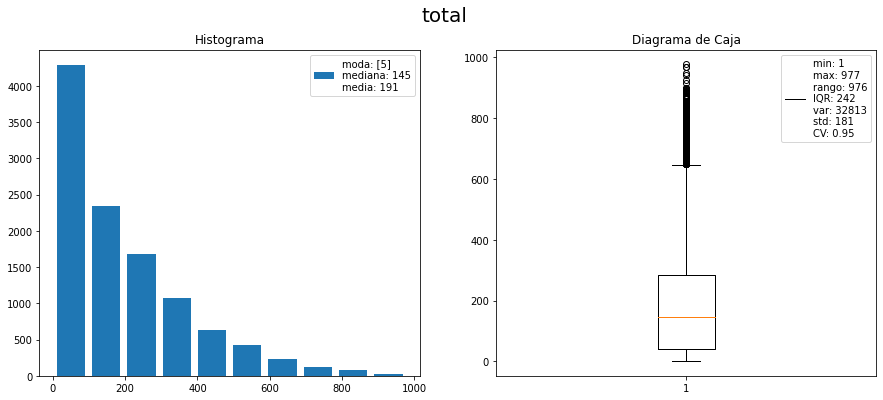

In [ ]:
tendencia(bikes, 'total')

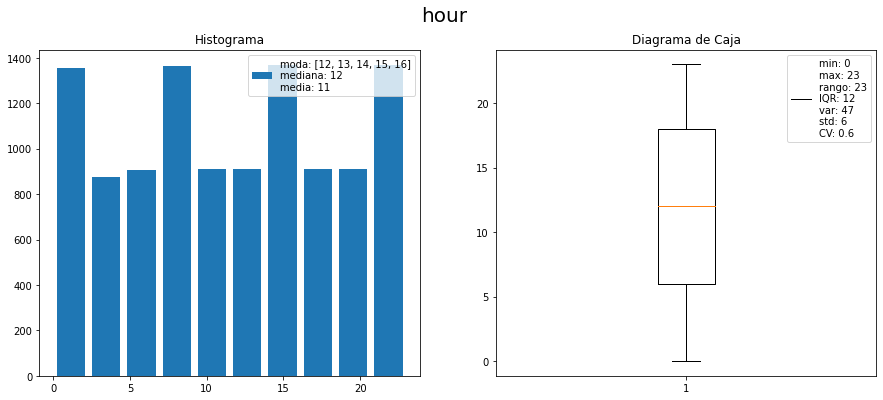

In [ ]:
tendencia(bikes, 'hour')

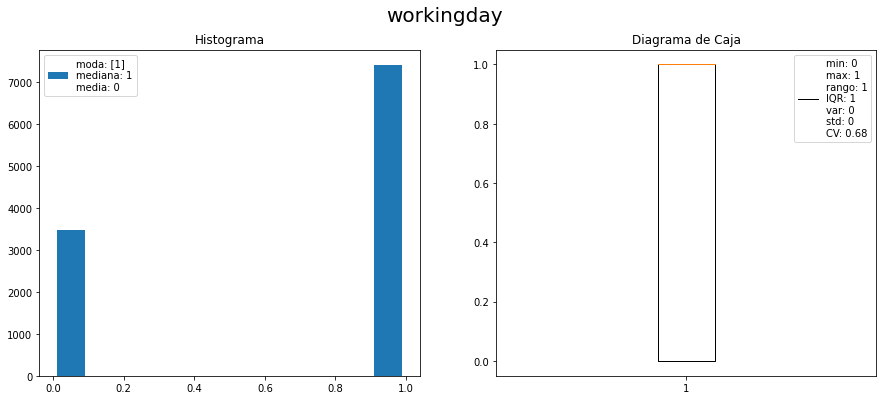

In [ ]:
tendencia(bikes, 'workingday')

### Data Fields - Diccionario de Datos
datetime - hourly date + timestamp 

season -  1 = spring, 2 = summer, 3 = fall, 4 = winter

holiday - whether the day is considered a holiday

workingday - whether the day is neither a weekend nor holiday

weather - 1: Clear, Few clouds, Partly cloudy, Partly cloudy
2: Mist + Cloudy, Mist + Broken clouds, Mist + Few clouds, Mist
3: Light Snow, Light Rain + Thunderstorm + Scattered clouds, Light Rain + Scattered clouds
4: Heavy Rain + Ice Pallets + Thunderstorm + Mist, Snow + Fog 

temp - temperature in Celsius

atemp - "feels like" temperature in Celsius

humidity - relative humidity

windspeed - wind speed

casual - number of non-registered user rentals initiated

registered - number of registered user rentals initiated

count - number of total rentals

### Variable Total:
Variable renombrada de la variable "count" que representa el número de bicicletas rentadas, es una variable numérica de tipo unimodal con moda en 5, mediana en 145 y media en 191, su valor mínimo es 1 y su máximo es 977, su desviación estándar es de 181 y presenta múltiples valores atípicos.
### Variable Hour:
Variable extraída de la variable "datetime", con 24 clases de datos que representan la hora militar en que una bicicleta es rentada, es una variable numérica de tipo multimodal con modas en (12,13, 14, 15 y 16), mediana en 12 y media en 11, su valor mínimo es 0 y su máximo es 23, su desviación estándar es de 6 y no presenta valores atípicos.

En su relación con la variable Total, se identifican promedios bajos entre las 23 y las 06 horas con un mínimo de 6.4 bicicletas rentadas a las 04 horas y promedios altos entre las horas (08, 16 a 19) con un pico de 362.7 bicicletas a las 08 horas y un máximo de 468.7 bicicletas a las 17 horas, por lo que se infiere que en la noche la renta de bicicletas es baja, en la mañana se presenta un pico de demanda a la hora de entrada al trabajo y en la tarde la demanda vuelve a aumentar por algunas horas al final de la jornada laboral.
### Variable WorkingDay:
Variable que representa si un día es laboral o no, su moda es 1, su valor mínimo es 0 y su máximo es 1, su desviación estándar es de 0 y no presenta valores atípicos.

En su relación con la variable Total, se identifica que cuando el día no es laboral el promedio de bicicletas rentadas es de 188.5 y cuando el día es laboral el promedio de bicicletas es de 193, por lo que se infiere que aunque la diferencia no es significativa si hay una mayor demanda de bicicletas en los días laborales.


### Punto 2 - Análisis de gráficos

Primero ejecute la celda 2.1 y asegúrese de comprender el código y el resultado. Luego, en cada una de celdas 2.2 y 2.3 escriba un código que genere una gráfica de las rentas promedio por hora cuando la variable "workingday" es igual a 0 e igual a 1, respectivamente. Analice y escriba sus hallazgos.

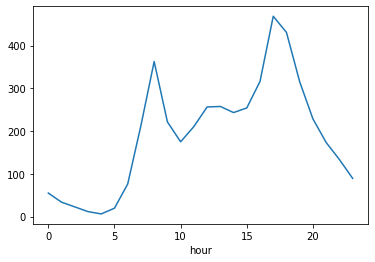

In [ ]:
# Celda 2.1 - rentas promedio para cada valor de la variable "hour"
bikes.groupby('hour').total.mean().plot()

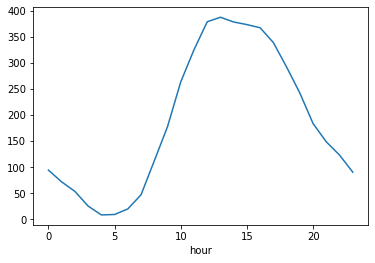

In [ ]:
# Celda 2.2 - "workingday"=0 escriba su código y hallazgos 
bikes[bikes.workingday == 0].groupby('hour').total.mean().plot()

Cuando el día no es laboral la demanda de bicicletas rentadas permanece alta entre las 08 y las 19 horas, e incluso en las horas de la noche su demanda es mayor que en los días laborales por lo que se infiere que su uso es principalmente para fines recreativos.

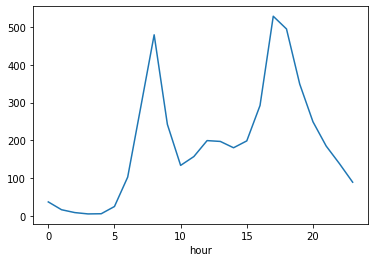

In [ ]:
# Celda 2.3 - "workingday"=1 escriba su código y hallazgos 
bikes[bikes.workingday == 1].groupby('hour').total.mean().plot()

Cuando el día es laboral la demanda de bicicletas rentadas presenta dos rangos de horario en los que se supera el promedio diario, los cuales son entre las 07 y 09 horas y entre las 16 y las 19 horas, por lo que se infiere que el primer pico de demanda está relacionado con el inicio de la jornada laboral y el segundo pico de demanda comienza con el fin de la jornada laboral pero se extiende algunas horas y es un poco más alto que el primer pico por lo que también puede estar relacionado con actividades recreativas.

### Punto 3 - Regresión lineal
En la celda 3 ajuste un modelo de regresión lineal a todo el conjunto de datos, utilizando "total" como variable de respuesta y "hour" y "workingday" como las únicas variables predictoras. Luego, imprima los coeficientes e interprételos. ¿Cuáles son las limitaciones de la regresión lineal en este caso?

Coeficientes:  [10.49206282  4.07248627]


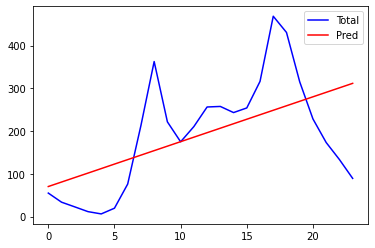

In [ ]:
# Celda 3
# Separación de variables predictoras (X) y variable de interés (y)
X = bikes[['hour','workingday']]
y = bikes.total

# Entrenamiento (fit) del modelo
reg = LinearRegression().fit(X, y)
print('Coeficientes: ', reg.coef_)

# Crea dataframe de respuesta
Z = X.copy()
Z['y'] = y

# Predecir
Z['pred'] = reg.predict(X)

#Z.groupby('hour').hour.mean()
plt.plot(Z.groupby('hour').hour.mean(), Z.groupby('hour').y.mean(), color="blue", label="Total")
plt.plot(Z.groupby('hour').hour.mean(), Z.groupby('hour').pred.mean(), color="red", label="Pred")
plt.legend()
plt.show()

Los coeficientes resultantes del modelo son 10.5 para la variable Hour y 4.0 para la variable WorkingDay, lo que significa que por cada hora adicional la renta de bicicletas aumenta en 10.5 y si es día laboral le suma un aumento de 4.0.

En la gráfica se presenta el comparativo del promedio de la variable "Total" y el promedio de la predicción "Pred", permitiendo identificar que la regresión lineal no es un modelo adecuado para predecir el comportamiento "no lineal" de la demanda de bicicletas rentadas, ya que ésta demanda presenta un comportamiento cíclico a lo largo del día

### Punto 4 - Árbol de decisión manual
En la celda 4 cree un árbol de decisiones para pronosticar la variable "total" iterando **manualmente** sobre las variables "hour" y  "workingday". El árbol debe tener al menos 6 nodos finales.

In [ ]:
# Celda 4

# Separar el dataset en train y test
XTrain, XTest, yTrain, yTest = train_test_split(bikes[['hour','workingday']], bikes.total, test_size=0.33, random_state=0)


# Definición de parámetros y criterios de parada
max_depth = None
num_pct = 10
max_features = None
min_loss=0.001


# Definición de la función que calcula el SSE
def sse(y_true, y_pred):
  return (np.square(y_true - y_pred)).sum()

# Definición de la función que calcula el MSE
def mse(y_true, y_pred):
  return (np.square(y_true - y_pred)).mean()


# Definición de la función sse_split para calular el SSE de una variable predictora j dado el punto de corte k
def sse_split(X_col, y, split):
    
    # Separa el dataset en izquierda y derecha
    filter_l = (X_col < split).values
    X_l = X_col[filter_l]
    X_r = X_col.loc[~filter_l]
    y_l = y.loc[filter_l]
    y_r = y.loc[~filter_l]
    
    # promedio para izquierda y derecha
    gorro_y = y.mean()
    gorro_y_l = y_l.mean()
    gorro_y_r = y_r.mean()
    
    # Retorna el SSE de izquiereda mas el SSE de derecha
    return sse(y_l, gorro_y_l) + sse(y_r, gorro_y_r)


# Definición de la función best_split para calcular cuál es la mejor variable y punto de cortepara hacer la bifurcación del árbol
def best_split(X, y, num_pct=10):
    
    features = range(X.shape[1])
    
    best_split = [0, 0, 10000000000]  # j, split, loss
    
    # Para todas las varibles 
    for j in features:
        
        splits = np.percentile(X.iloc[:, j], np.arange(0, 100, 100.0 / (num_pct+1)).tolist())
        splits = np.unique(splits)[1:]
        
        # Para cada partición
        for split in splits:
            loss = sse_split(X.iloc[:, [j]], y, split)
                        
            if loss < best_split[2]:
                best_split = [j, split, loss]
    
    return best_split


# Definición de la función tree_grow para hacer un crecimiento recursivo del árbol
def tree_grow(X, y, level=0, min_loss=0.001, max_depth=None, num_pct=10):
    
    # Si solo es una observación
    if X.shape[0] == 1:
        tree = dict(y_pred=y.iloc[:1].values[0], y_prob=0.5, level=level, split=-1, n_samples=1, loss=0)
        return tree
    
    # Calcular la mejor división
    j, split, loss = best_split(X, y, num_pct)
    
    # Guardar el árbol y estimar la predicción
    y_pred = y.mean() 
    y_prob = (y.sum() + 1.0) / (y.shape[0] + 2.0)  # Corrección Laplace 
    
    tree = dict(y_pred=y_pred, y_prob=y_prob, level=level, split=-1, n_samples=X.shape[0], loss=loss)
    # Revisar el criterio de parada 
    if loss < min_loss:
        return tree
    if max_depth is not None:
        if level >= max_depth:
            return tree   
    
    # Continuar creando la partición
    filter_l = X.iloc[:, j] < split
    X_l, y_l = X.loc[filter_l], y.loc[filter_l]
    X_r, y_r = X.loc[~filter_l], y.loc[~filter_l]
    tree['split'] = [j, split]

    # Siguiente iteración para cada partición
    
    tree['sl'] = tree_grow(X_l, y_l, level + 1, min_loss=min_loss, max_depth=max_depth, num_pct=num_pct)
    tree['sr'] = tree_grow(X_r, y_r, level + 1, min_loss=min_loss, max_depth=max_depth, num_pct=num_pct)
    
    return tree


# Aplicación de la función tree_grow al dataset de Train
treeManual = tree_grow(XTrain, yTrain, level=0, min_loss=0.001, max_depth=3, num_pct=20)
treeManual

{'level': 0,
 'loss': 164813348.2970792,
 'n_samples': 7293,
 'sl': {'level': 1,
  'loss': 2680124.385789589,
  'n_samples': 2141,
  'sl': {'level': 2,
   'loss': 1412855.7162268094,
   'n_samples': 1827,
   'sl': {'level': 3,
    'loss': 613185.752600048,
    'n_samples': 623,
    'split': -1,
    'y_pred': 44.8876404494382,
    'y_prob': 44.7456},
   'split': [0, 2.0],
   'sr': {'level': 3,
    'loss': 312010.3635643913,
    'n_samples': 1204,
    'split': -1,
    'y_pred': 15.093023255813954,
    'y_prob': 15.068822553897181},
   'y_pred': 25.25287356321839,
   'y_prob': 25.225806451612904},
  'split': [0, 6.0],
  'sr': {'level': 2,
   'loss': 469049.8772660007,
   'n_samples': 314,
   'sl': {'level': 3,
    'loss': 10000000000,
    'n_samples': 102,
    'split': -1,
    'y_pred': 20.745098039215687,
    'y_prob': 20.35576923076923},
   'split': [1, 1.0],
   'sr': {'level': 3,
    'loss': 10000000000,
    'n_samples': 212,
    'split': -1,
    'y_pred': 100.10849056603773,
    'y_pr

MSE arbol Manual:  18362.54033071873


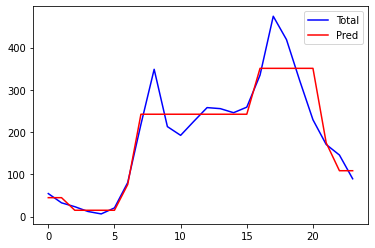

In [ ]:
# Definición de la función tree_predict para hacer predicciones según las variables 'X' y el árbol 'tree'

def tree_predict(X, tree, proba=False):
    
    predicted = np.ones(X.shape[0])

    # Revisar si es el nodo final
    if tree['split'] == -1:
        if not proba:
            predicted = predicted * tree['y_pred']
        else:
            predicted = predicted * tree['y_prob']
            
    else:
        
        j, split = tree['split']
        filter_l = (X.iloc[:, j] < split)
        X_l = X.loc[filter_l]
        X_r = X.loc[~filter_l]

        if X_l.shape[0] == 0:  # Si el nodo izquierdo está vacio solo continua con el derecho 
            predicted[~filter_l] = tree_predict(X_r, tree['sr'], proba)
        elif X_r.shape[0] == 0:  #  Si el nodo derecho está vacio solo continua con el izquierdo
            predicted[filter_l] = tree_predict(X_l, tree['sl'], proba)
        else:
            predicted[filter_l] = tree_predict(X_l, tree['sl'], proba)
            predicted[~filter_l] = tree_predict(X_r, tree['sr'], proba)

    return predicted

# Ejecución de función tree_predict
yPredManual = tree_predict(XTest, treeManual)
print('MSE arbol Manual: ', mse(yTest, yPredManual))

# Crea dataframe de respuesta
Zmanual = XTest.copy()
Zmanual['y'] = yTest

# Predecir
Zmanual['pred'] = yPredManual

#Z.groupby('hour').hour.mean()
plt.plot(Zmanual.groupby('hour').hour.mean(), Zmanual.groupby('hour').y.mean(), color="blue", label="Total")
plt.plot(Zmanual.groupby('hour').hour.mean(), Zmanual.groupby('hour').pred.mean(), color="red", label="Pred")
plt.legend()
plt.show()

### Punto 5 - Árbol de decisión con librería
En la celda 5 entrene un árbol de decisiones con la **librería sklearn**, usando las variables predictoras "hour" y "workingday" y calibre los parámetros que considere conveniente para obtener un mejor desempeño. Comente el desempeño del modelo con alguna métrica de desempeño de modelos de clasificación y compare desempeño con el modelo del punto 3.

Text(0, 0.5, 'MSE')

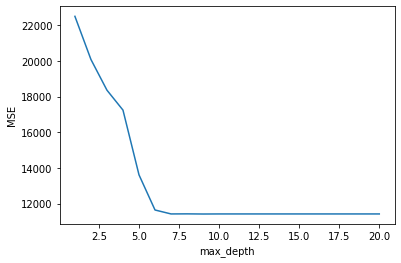

In [ ]:
# Celda 5
# Lista de valores para calibrar el criterio de parada de máxima profundidad (max_depth)
max_depth_range = range(1, 21)

# Lista para guardar los valores del RMSE para cada valor de máxima profundidad (max_depth)
mse_scores = []

# Loop para obtener el desempeño del modelo de acuerdo con la máxima profundidad
for depth in max_depth_range:
    # Definición del árbol de decisión usando DecisionTreeClassifier de la libreria sklearn
    tree = DecisionTreeRegressor(max_depth=depth, random_state=1)
    # Entrena el árbol de regresión con el dataset Train
    tree.fit(XTrain, yTrain)
    # Predice con el dataset Test
    yPred = tree.predict(XTest)
    # Calcula MSE
    mse_scores.append(mse(yTest, yPred))

# Gráfica max_depth versus MSE (error del modelo)
plt.plot(max_depth_range, mse_scores)
plt.xlabel('max_depth')
plt.ylabel('MSE')

MSE del modelo del punto 3:  27541.25525249845
MSE arbol con libreria:  11637.921786519417


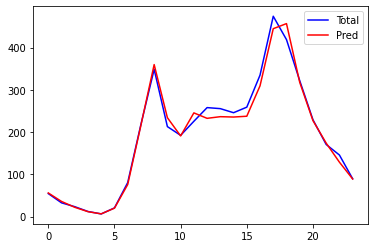

In [ ]:
# Definición del árbol de decisión
tree = DecisionTreeRegressor(max_depth=6, random_state=1)
# Entrena el árbol de regresión con el dataset Train
tree.fit(XTrain, yTrain)
# Predice con el dataset Test
yPredLibreria = tree.predict(XTest)
# Calcula MSE
print('MSE del modelo del punto 3: ', mse(Z.y, Z.pred))
print('MSE arbol con libreria: ', mse(yTest, yPredLibreria))

# Crea dataframe de respuesta
ZLibreria = XTest.copy()
ZLibreria['y'] = yTest

# Predecir
ZLibreria['pred'] = yPredLibreria

#Z.groupby('hour').hour.mean()
plt.plot(ZLibreria.groupby('hour').hour.mean(), ZLibreria.groupby('hour').y.mean(), color="blue", label="Total")
plt.plot(ZLibreria.groupby('hour').hour.mean(), ZLibreria.groupby('hour').pred.mean(), color="red", label="Pred")
plt.legend()
plt.show()

El parámetro de calibración utilizado es max_depth y se obtuvo el mejor desempeño a partir del valor 6.

La métrica utilizada para comparar los modelos es el MSE con un resultado de 27541 para el modelo del punto 3, 18362 para el modelo de árbol manual del punto 4 y 11637 para el árbol usando librería del punto 5.

## Parte B - Métodos de ensamblajes
En esta parte del taller se usará el conjunto de datos de Popularidad de Noticias Online. El objetivo es predecir si la notica es popular o no, la popularidad esta dada por la cantidad de reacciones en redes sociales. Para más detalles puede visitar el sigueinte enlace: [datos](https://archive.ics.uci.edu/ml/datasets/online+news+popularity).

### Datos popularidad de noticias

In [ ]:
# Lectura de la información de archivo .csv
df = pd.read_csv('https://raw.githubusercontent.com/albahnsen/MIAD_ML_and_NLP/main/datasets/mashable.csv', index_col=0)
df.head()

,url,timedelta,n_tokens_title,n_tokens_content,n_unique_tokens,n_non_stop_words,n_non_stop_unique_tokens,num_hrefs,num_self_hrefs,num_imgs,...,min_positive_polarity,max_positive_polarity,avg_negative_polarity,min_negative_polarity,max_negative_polarity,title_subjectivity,title_sentiment_polarity,abs_title_subjectivity,abs_title_sentiment_polarity,Popular
0,http://mashable.com/2014/12/10/cia-torture-rep...,28.0,9.0,188.0,0.732620,1.0,0.844262,5.0,1.0,1.0,...,0.200000,0.80,-0.487500,-0.60,-0.250000,0.9,0.8,0.4,0.8,1
1,http://mashable.com/2013/10/18/bitlock-kicksta...,447.0,7.0,297.0,0.653199,1.0,0.815789,9.0,4.0,1.0,...,0.160000,0.50,-0.135340,-0.40,-0.050000,0.1,-0.1,0.4,0.1,0
2,http://mashable.com/2013/07/24/google-glass-po...,533.0,11.0,181.0,0.660377,1.0,0.775701,4.0,3.0,1.0,...,0.136364,1.00,0.000000,0.00,0.000000,0.3,1.0,0.2,1.0,0
3,http://mashable.com/2013/11/21/these-are-the-m...,413.0,12.0,781.0,0.497409,1.0,0.677350,10.0,3.0,1.0,...,0.100000,1.00,-0.195701,-0.40,-0.071429,0.0,0.0,0.5,0.0,0
4,http://mashable.com/2014/02/11/parking-ticket-...,331.0,8.0,177.0,0.685714,1.0,0.830357,3.0,2.0,1.0,...,0.100000,0.55,-0.175000,-0.25,-0.100000,0.0,0.0,0.5,0.0,0


In [ ]:
# Definición variable de interes y variables predictoras
X = df.drop(['url', 'Popular'], axis=1)
y = df['Popular']
y.mean()

0.5

In [ ]:
# División de la muestra en set de entrenamiento y prueba
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1)

### Punto 6 - Árbol de decisión y regresión logística
En la celda 6 construya un árbol de decisión y una regresión logística. Para el árbol calibre al menos un parámetro y evalúe el desempeño de cada modelo usando las métricas de Accuracy y F1-Score.

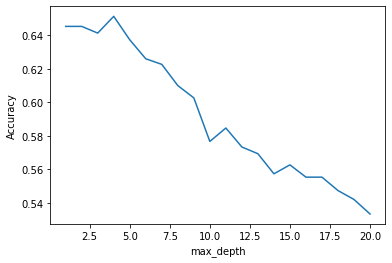

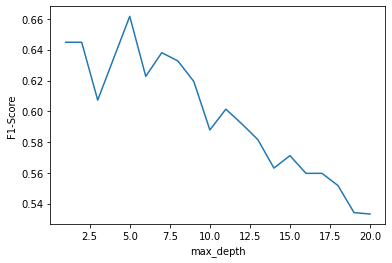

Arbol Accuracy:  0.6373333333333333
Arbol F1-Score:  0.6616915422885573


In [ ]:
# Celda 6

# Arbol de decisión
# Lista de valores para calibrar el criterio de parada de máxima profundidad (max_depth)
max_depth_range = range(1, 21)

# Lista para guardar los valores del RMSE para cada valor de máxima profundidad (max_depth)
accuracy_clftree = []
f1_clftree = []

# Loop para obtener el desempeño del modelo de acuerdo con la máxima profundidad
for depth in max_depth_range:
    # Definición del árbol de decisión usando DecisionTreeClassifier de la libreria sklearn
    clftree = DecisionTreeClassifier(max_depth=depth, random_state=1)
    # Entrenar arbol
    clftree.fit(X_train, y_train)
    # Predecir
    y_pred_arbol = clftree.predict(X_test)
    accuracy_clftree.append(metrics.accuracy_score(y_pred_arbol, y_test))
    f1_clftree.append(metrics.f1_score(y_pred_arbol, y_test))

# Gráfica max_depth versus metricas
plt.plot(max_depth_range, accuracy_clftree)
plt.xlabel('max_depth')
plt.ylabel('Accuracy')
plt.show()

plt.plot(max_depth_range, f1_clftree)
plt.xlabel('max_depth')
plt.ylabel('F1-Score')
plt.show()

print('Arbol Accuracy: ', accuracy_clftree[4])
print('Arbol F1-Score: ', f1_clftree[4])

In [ ]:
# Regresión Logistica
# modelo LogReg
logreg = LogisticRegression()
# Entrenar modelo LogReg
logreg.fit(X_train, y_train)
# Predecir
y_pred_logreg = logreg.predict(X_test)
print('Regreción Logística Accuracy: ', metrics.accuracy_score(y_pred_logreg, y_test))
print('Regreción Logística F1-Score: ', metrics.f1_score(y_pred_logreg, y_test))

Regreción Logística Accuracy:  0.614
Regreción Logística F1-Score:  0.6106254203093476


Para el modelo del Arbol con un max_depth de 5 la métrica de accuracy es 0.637 y de F1-Score es 0.661.

Para el modelo de Regresión Logistica la métrica de accuracy es 0.614 y de F1-Score es 0.610.

### Punto 7 - Votación Mayoritaria
En la celda 7 elabore un esamble con la metodología de **Votación mayoritaria** compuesto por 300 muestras bagged para cada uno de los siguientes escenarios:

-100 árboles de decisión donde max_depth = None\
-100 árboles de decisión donde max_depth = 2\
-100 regresiones logísticas

Evalúe los modelos utilizando las métricas de Accuracy y F1-Score.

In [ ]:
# Celda 7
# Definición del modelo BaggingClassifier de la libreria sklearn
# escenario 1: 100 árboles de decisión donde max_depth = None
clfvotmay1 = BaggingClassifier(base_estimator=DecisionTreeClassifier(max_depth=None), max_samples=300,
                               n_estimators=100, bootstrap=True, random_state=42, n_jobs=-1, oob_score=True)

# Predicción y desempeño al hacer votación mayoritaria escenario 1
clfvotmay1.fit(X_train, y_train)
y_predvotmay1 = clfvotmay1.predict(X_test)
print('Votación mayoritaria escenario 1 F1-Score:',metrics.f1_score(y_predvotmay1, y_test),
      'Accuracy:', metrics.accuracy_score(y_predvotmay1, y_test))

Votación mayoritaria escenario 1 F1-Score: 0.6567567567567568 Accuracy: 0.6613333333333333


In [ ]:
# escenario 2: 100 árboles de decisión donde max_depth = 2
clfvotmay2 = BaggingClassifier(base_estimator=DecisionTreeClassifier(max_depth=2), max_samples=300,
                               n_estimators=100, bootstrap=True, random_state=42, n_jobs=-1, oob_score=True)

# Predicción y desempeño al hacer votación mayoritaria escenario 1
clfvotmay2.fit(X_train, y_train)
y_predvotmay2 = clfvotmay2.predict(X_test)
print('Votación mayoritaria escenario 2 F1-Score:',metrics.f1_score(y_predvotmay2, y_test),
      'Accuracy:', metrics.accuracy_score(y_predvotmay2, y_test))

Votación mayoritaria escenario 2 F1-Score: 0.631578947368421 Accuracy: 0.6453333333333333


In [ ]:
# escenario 3: 100 regresiones logísticas
clfvotmay3 = BaggingClassifier(base_estimator=LogisticRegression(), max_samples=300,
                               n_estimators=100, bootstrap=True, random_state=42, n_jobs=-1, oob_score=True)

# Predicción y desempeño al hacer votación mayoritaria escenario 1
clfvotmay3.fit(X_train, y_train)
y_predvotmay3 = clfvotmay3.predict(X_test)
print('Votación mayoritaria escenario 3 F1-Score:',metrics.f1_score(y_predvotmay3, y_test),
      'Accuracy:', metrics.accuracy_score(y_predvotmay3, y_test))

Votación mayoritaria escenario 3 F1-Score: 0.6125760649087221 Accuracy: 0.618


In [ ]:
# Predicción para los datos del set de test con cada modelo y escenario
y_pred_df_votmay = pd.DataFrame(index=X_test.index, columns=list(range(3)))
y_pred_df_votmay.iloc[:, 0] = y_predvotmay1
y_pred_df_votmay.iloc[:, 1] = y_predvotmay2
y_pred_df_votmay.iloc[:, 2] = y_predvotmay3

# Votación mayoritaria
y_pred_votmay = (y_pred_df_votmay.sum(axis=1) >= (3 / 2)).astype(np.int)
print('Votación mayoritaria F1-Score:',metrics.f1_score(y_pred_votmay, y_test),
      'Accuracy:', metrics.accuracy_score(y_pred_votmay, y_test))

Votación mayoritaria F1-Score: 0.6368638239339752 Accuracy: 0.648


#### Resultados votación mayoritaria:
escenario 1 F1-Score: 0.6567 Accuracy: 0.6613

escenario 2 F1-Score: 0.6315 Accuracy: 0.6453

escenario 3 F1-Score: 0.6125 Accuracy: 0.618

En este caso los mejores resultados los brinda el escenario 1

### Punto 8 - Votación Ponderada
En la celda 8 elabore un ensamble con la metodología de **Votación ponderada** compuesto por 300 muestras bagged para los mismos tres escenarios del punto 7. Evalúe los modelos utilizando las métricas de Accuracy y F1-Score

In [ ]:
# Celda 8
# Obtención de los pesos alpha de cada modelo de acuerdo al error OOB escenario 1
errors = np.zeros(clfvotmay1.n_estimators)
y_pred_all_ = np.zeros((X_test.shape[0], clfvotmay1.n_estimators))

for i in range(clfvotmay1.n_estimators):
    oob_sample = ~clfvotmay1.estimators_samples_[i]
    y_pred_ = clfvotmay1.estimators_[i].predict(X_train.values[oob_sample])
    errors[i] = metrics.accuracy_score(y_pred_, y_train.values[oob_sample])
    y_pred_all_[:, i] = clfvotmay1.estimators_[i].predict(X_test)
    
alpha = (1 - errors) / (1 - errors).sum()
y_pred_votpon1 = (np.sum(y_pred_all_ * alpha, axis=1) >= 0.5).astype(np.int)

# Desempeño al hacer votación ponderada escenario 1
print('Votación ponderada escenario 1 F1-Score:', metrics.f1_score(y_pred_votpon1, y_test),
      'Accuracy:', metrics.accuracy_score(y_pred_votpon1, y_test))

Votación ponderada escenario 1 F1-Score: 0.6631087391594397 Accuracy: 0.6633333333333333


In [ ]:
# Obtención de los pesos alpha de cada modelo de acuerdo al error OOB escenario 2
errors = np.zeros(clfvotmay2.n_estimators)
y_pred_all_ = np.zeros((X_test.shape[0], clfvotmay2.n_estimators))

for i in range(clfvotmay2.n_estimators):
    oob_sample = ~clfvotmay2.estimators_samples_[i]
    y_pred_ = clfvotmay2.estimators_[i].predict(X_train.values[oob_sample])
    errors[i] = metrics.accuracy_score(y_pred_, y_train.values[oob_sample])
    y_pred_all_[:, i] = clfvotmay2.estimators_[i].predict(X_test)
    
alpha = (1 - errors) / (1 - errors).sum()
y_pred_votpon2 = (np.sum(y_pred_all_ * alpha, axis=1) >= 0.5).astype(np.int)

# Desempeño al hacer votación ponderada escenario 1
print('Votación ponderada escenario 2 F1-Score:', metrics.f1_score(y_pred_votpon2, y_test),
      'Accuracy:', metrics.accuracy_score(y_pred_votpon2, y_test))

Votación ponderada escenario 2 F1-Score: 0.6324549237170597 Accuracy: 0.6466666666666666


In [ ]:
# Obtención de los pesos alpha de cada modelo de acuerdo al error OOB escenario 3
errors = np.zeros(clfvotmay3.n_estimators)
y_pred_all_ = np.zeros((X_test.shape[0], clfvotmay3.n_estimators))

for i in range(clfvotmay3.n_estimators):
    oob_sample = ~clfvotmay3.estimators_samples_[i]
    y_pred_ = clfvotmay3.estimators_[i].predict(X_train.values[oob_sample])
    errors[i] = metrics.accuracy_score(y_pred_, y_train.values[oob_sample])
    y_pred_all_[:, i] = clfvotmay3.estimators_[i].predict(X_test)
    
alpha = (1 - errors) / (1 - errors).sum()
y_pred_votpon3 = (np.sum(y_pred_all_ * alpha, axis=1) >= 0.5).astype(np.int)

# Desempeño al hacer votación ponderada escenario 1
print('Votación ponderada escenario 3 F1-Score:', metrics.f1_score(y_pred_votpon3, y_test),
      'Accuracy:', metrics.accuracy_score(y_pred_votpon3, y_test))

Votación ponderada escenario 3 F1-Score: 0.6181818181818182 Accuracy: 0.622


#### Resultados votación ponderada:
escenario 1 F1-Score: 0.6631 Accuracy: 0.6633

escenario 2 F1-Score: 0.6324 Accuracy: 0.6466

escenario 3 F1-Score: 0.6181 Accuracy: 0.622

En este caso los mejores resultados los brinda el escenario 1

### Punto 9 - Comparación y análisis de resultados
En la celda 9 comente sobre los resultados obtenidos con las metodologías usadas en los puntos 7 y 8, compare los resultados y enuncie posibles ventajas o desventajas de cada una de ellas.

In [ ]:
# Celda 9


### Resultados:

#### Votación mayoritaria:
escenario 1 F1-Score: 0.6567 Accuracy: 0.6613

escenario 2 F1-Score: 0.6315 Accuracy: 0.6453

escenario 3 F1-Score: 0.6125 Accuracy: 0.618

#### Votación ponderada:
escenario 1 F1-Score: 0.6631 Accuracy: 0.6633

escenario 2 F1-Score: 0.6324 Accuracy: 0.6466

escenario 3 F1-Score: 0.6181 Accuracy: 0.622

En general se obtuvieron mejores resultados con la votación ponderada para cada uno de los 3 escenarios.

En este caso la ventaja de la votación ponderada es que se obtienen mejores resultados.

La desventaja de la votación ponderada es que implica pasos y procesamiento adicional y como en este caso la mejora de los resultados es pequeña en comparación con la votación mayoritaria, en los entornos donde la carga computacional sea una restricción es más ventajoso utilizar la votación mayoritaria.
